<a href="https://colab.research.google.com/github/keshab97/checkIamRipe/blob/master/pytorch_class_mangoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import copy
from torch.optim import lr_scheduler
from torchvision import datasets
from torchvision import models
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import numpy as np

plt.ion()   # interactive mode

In [4]:
from google.colab import drive
drive.mount("drive")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [5]:
!ls drive/My\ Drive

 a0409a00-8-dataset_dp.zip	  sample_submission.csv
 bee_data.csv			  spam_ham_filter
 bee_imgs			  ssd_mobilenet_v1_coco_2018_01_28
'Colab Notebooks'		  test.csv
 honey-bee-annotated-images.zip   test_csv_mangoes.csv
 hymenoptera_data		  test_img
 mango_dataset			  tfrecords.py
 mango_images			  train.csv
 mango_xml			  train_csv_mangoes.csv
 PER				  train_img
 prof.jpg


In [0]:
#data augmuntation and normalization on train and test data
transform_data = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.480, 0.460, 0.410], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.480, 0.460, 0.410], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
#datapath
data_dir = 'drive/My Drive/mango_dataset'

#image dataset
imgdatasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),transform_data[x]) for x in ['train', 'val']}

#dataloaders
dataloaders = {x: torch.utils.data.DataLoader(imgdatasets[x], batch_size=4,shuffle=True, num_workers=4) for x in ['train', 'val']}

#size of datasets
datasetsize = {x: len(imgdatasets[x]) for x in ['train', 'val']}

#binary classnames
class_names = imgdatasets['train'].classes

#check cpu or gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

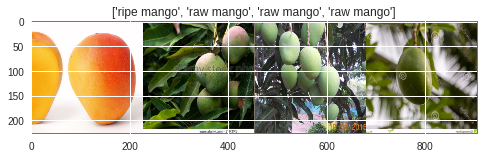

In [9]:
def imshow(imageinput, title=None):
    imageinput = imageinput.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imageinput = std * imageinput + mean
    imageinput = np.clip(imageinput, 0, 1)
    plt.imshow(imageinput)
    if title is not None:
        plt.title(title)
    plt.pause(0.1)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x]+" mango" for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    #since = time.time()
    #model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    bestacc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                #training 
                model.train() 
            else:
                #evaluate
                model.eval()   

            running_loss = 0.0
            running_corrects = 0
            
            #iterate over given data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward track history
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward and optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / datasetsize[phase]
            epoch_acc = running_corrects.double() / datasetsize[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > bestacc:
                bestacc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    #time_elapsed = time.time() - since
    #print('Training complete in {:.0f}m {:.0f}s'.format(
        #time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(bestacc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
#visualization of model
def visualize_model(model, num_images=2):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predict classes: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                  
        model.train(mode=was_training)

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [20]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
train Loss: 0.5973 Acc: 0.6889
val Loss: 1.0745 Acc: 0.6429

Epoch 1/24
train Loss: 0.3518 Acc: 0.8778
val Loss: 0.2852 Acc: 0.7857

Epoch 2/24
train Loss: 0.3352 Acc: 0.8667
val Loss: 0.4742 Acc: 0.7857

Epoch 3/24
train Loss: 0.2653 Acc: 0.9111
val Loss: 0.4485 Acc: 0.7857

Epoch 4/24
train Loss: 0.2453 Acc: 0.8889
val Loss: 1.0571 Acc: 0.5714

Epoch 5/24
train Loss: 0.3549 Acc: 0.8444
val Loss: 0.6421 Acc: 0.7857

Epoch 6/24
train Loss: 0.4561 Acc: 0.8333
val Loss: 0.2295 Acc: 0.9286

Epoch 7/24
train Loss: 0.3474 Acc: 0.8889
val Loss: 0.2803 Acc: 0.9286

Epoch 8/24
train Loss: 0.3415 Acc: 0.9111
val Loss: 0.1988 Acc: 0.9286

Epoch 9/24
train Loss: 0.2172 Acc: 0.9444
val Loss: 0.1537 Acc: 0.9286

Epoch 10/24
train Loss: 0.1287 Acc: 0.9000
val Loss: 0.2130 Acc: 0.8571

Epoch 11/24
train Loss: 0.1213 Acc: 0.9556
val Loss: 0.2129 Acc: 0.8571

Epoch 12/24
train Loss: 0.4667 Acc: 0.8778
val Loss: 0.2454 Acc: 0.8571

Epoch 13/24
train Loss: 0.2362 Acc: 0.9444
val Loss: 0.2590 A

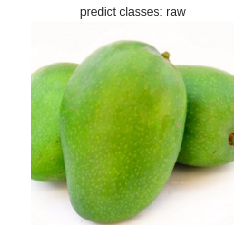

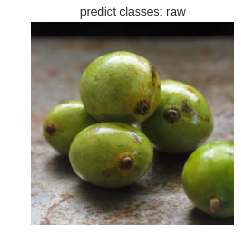

In [21]:
visualize_model(model_ft)

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)

In [0]:
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizerc = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
explrscheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [28]:
modelc = train_model(model_conv, criterion, optimizerc,explrscheduler, num_epochs=21)

Epoch 0/20
train Loss: 0.9419 Acc: 0.5000
val Loss: 0.9335 Acc: 0.5000

Epoch 1/20
train Loss: 0.6190 Acc: 0.6889
val Loss: 0.9588 Acc: 0.6429

Epoch 2/20
train Loss: 0.3136 Acc: 0.8667
val Loss: 0.7072 Acc: 0.6429

Epoch 3/20
train Loss: 0.3698 Acc: 0.8000
val Loss: 0.7922 Acc: 0.7143

Epoch 4/20
train Loss: 0.5474 Acc: 0.7333
val Loss: 0.5916 Acc: 0.6429

Epoch 5/20
train Loss: 0.3338 Acc: 0.8667
val Loss: 0.7875 Acc: 0.7143

Epoch 6/20
train Loss: 0.3475 Acc: 0.8444
val Loss: 0.5117 Acc: 0.7857

Epoch 7/20
train Loss: 0.4944 Acc: 0.8333
val Loss: 0.6053 Acc: 0.7143

Epoch 8/20
train Loss: 0.3210 Acc: 0.8222
val Loss: 0.5043 Acc: 0.7857

Epoch 9/20
train Loss: 0.2460 Acc: 0.8889
val Loss: 0.7011 Acc: 0.7143

Epoch 10/20
train Loss: 0.2194 Acc: 0.9111
val Loss: 0.6772 Acc: 0.6429

Epoch 11/20
train Loss: 0.5284 Acc: 0.7778
val Loss: 0.9982 Acc: 0.6429

Epoch 12/20
train Loss: 0.6672 Acc: 0.7333
val Loss: 0.7871 Acc: 0.6429

Epoch 13/20
train Loss: 0.2214 Acc: 0.9444
val Loss: 0.7429 A

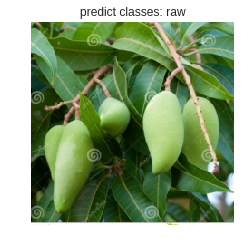

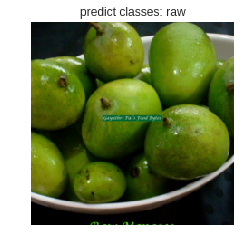

In [29]:
visualize_model(model_conv)
#plt.ioff()
plt.show()